In [8]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import math


In [2]:
# params
seed = 42

Данные существуют в виде нескольких отдельных таблиц, составлявших базу данных в соответствии со следующей картой: 
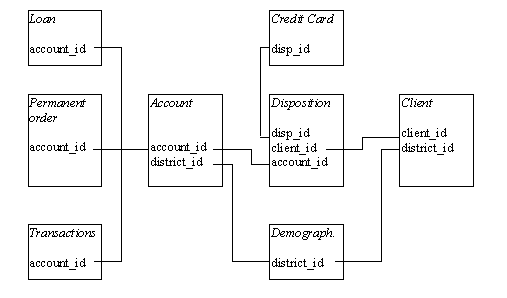

Другая схема приведена в [статье](https://towardsdatascience.com/loan-default-prediction-an-end-to-end-ml-project-with-real-bank-data-part-1-1405f7aecb9e):  
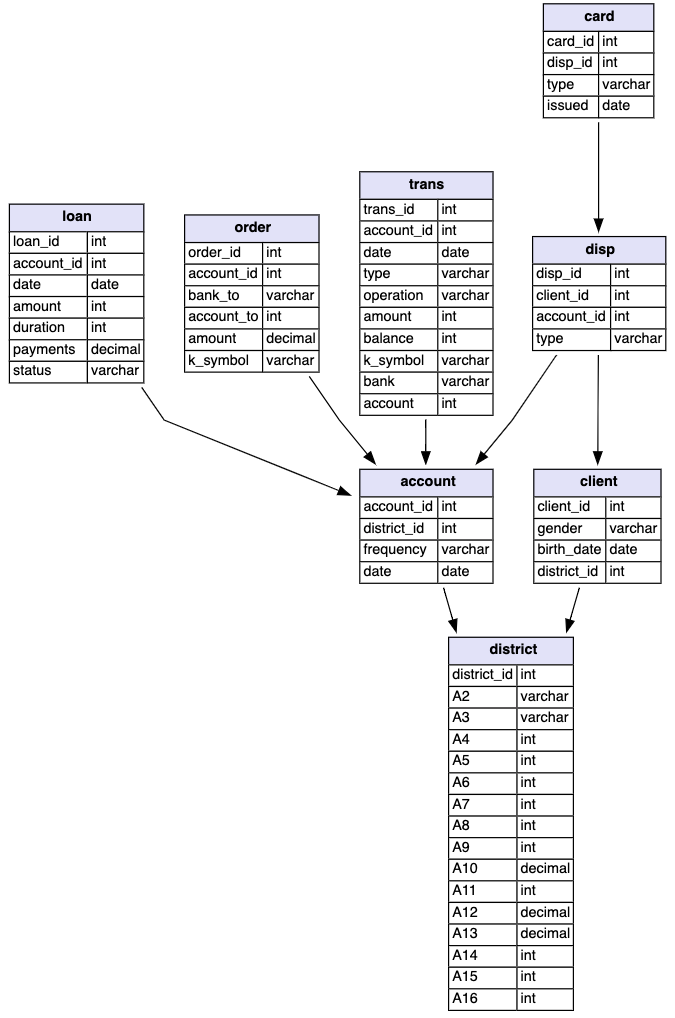

Там же дано описание таблиц: 

account (4500 objects in the file ACCOUNT.ASC) — each record describes static characteristics of an account.

client (5369 objects in the file CLIENT.ASC) — each record describes characteristics of a client.

disposition (5369 objects in the file DISP.ASC) — each record relates together a client with an account i.e. this relation describes the rights of clients to operate accounts.

permanent order (6471 objects in the file ORDER.ASC) — each record describes characteristics of a payment order.

transaction (1056320 objects in the file TRANS.ASC) — each record describes one transaction on an account.

loan (682 objects in the file LOAN.ASC) — each record describes a loan granted for a given account.

credit card (892 objects in the file CARD.ASC) — each record describes a credit card issued to an account.

demographic data (77 objects in the file DISTRICT.ASC) — each record describes demographic characteristics of a district.


Объединим их.

In [3]:
dfs = [pd.read_csv("./Data_tables/" + table_name, sep = ";", low_memory = False) for table_name in os.listdir("./Data_tables")]

dfs_names = [table_name.replace(".csv", "") for table_name in os.listdir("./Data_tables")]

dfs = dict(zip(dfs_names, dfs))

In [81]:
#example of a table
dfs["district"]

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.38,5.66,99,4063,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.73,5.88,107,3736,2807


Кстати, наблюдается проблема: в файле district нет ключа dist_id, но на него очень похожа переменная A1

In [45]:
df = dfs["loan"].merge(dfs["order"], on = "account_id", suffixes = ("_loan", "_order"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["trans"], on = "account_id", suffixes = ("", "_trans"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["account"], on = "account_id", suffixes = ("", "_account"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["disp"], on = "account_id", suffixes = ("", "_disp"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["card"], on = "disp_id", suffixes = ("", "_card"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["client"], on = ["client_id", "district_id"], suffixes = ("", "_client"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df = df.merge(dfs["district"], left_on = "district_id", right_on = "A1", suffixes = ("", "_district"), how = "outer")
print(df.columns)
print(f"Length of the table is {df.shape[0]}")
df.drop(["A1"], axis = 1, inplace = True)
print(df.columns)
print(f"Length of the table is {df.shape[0]}")


Index(['loan_id', 'account_id', 'date', 'amount_loan', 'duration', 'payments',
       'status', 'order_id', 'bank_to', 'account_to', 'amount_order',
       'k_symbol'],
      dtype='object')
Length of the table is 6471
Index(['loan_id', 'account_id', 'date', 'amount_loan', 'duration', 'payments',
       'status', 'order_id', 'bank_to', 'account_to', 'amount_order',
       'k_symbol', 'trans_id', 'date_trans', 'type', 'operation', 'amount',
       'balance', 'k_symbol_trans', 'bank', 'account'],
      dtype='object')
Length of the table is 1858450
Index(['loan_id', 'account_id', 'date', 'amount_loan', 'duration', 'payments',
       'status', 'order_id', 'bank_to', 'account_to', 'amount_order',
       'k_symbol', 'trans_id', 'date_trans', 'type', 'operation', 'amount',
       'balance', 'k_symbol_trans', 'bank', 'account', 'district_id',
       'frequency', 'date_account'],
      dtype='object')
Length of the table is 1858450
Index(['loan_id', 'account_id', 'date', 'amount_loan', 'durati

### Список факторов:

К сожалению, не удалось найти список факторов с описаниями, поэтому придетя опираться на названия переменных (которые, впрочем, выглядят достаточно осмысленно). К счастью, есть интерпретация значений переменной с дефолтами (status):


A: Contract finished, no problems.

B: Contract finished, loan not paid.

C: Running contract, okay so far.

D: Running contract, client in debt.


In [92]:
df["status"].unique()

array(['B', 'A', nan, 'C', 'D'], dtype=object)

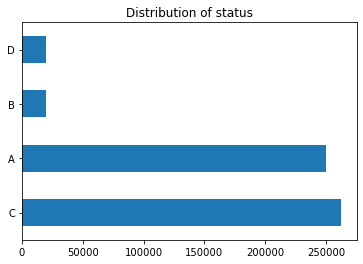

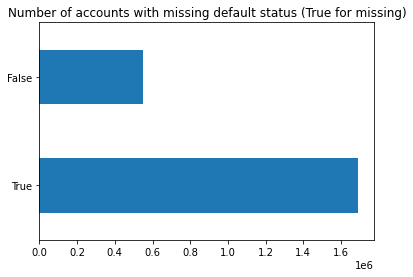

In [162]:
df.status.value_counts().plot.barh()
plt.title("Distribution of status")
plt.show()

df.status.isnull().value_counts().plot.barh()
plt.title("Number of accounts with missing default status (True for missing)")
plt.show()

Для единообразия нотации, создадим новую зависимую переменную target:

In [49]:
df['target'] = np.where((df["status"] == "D")|(df["status"] == "B"), 1, 0)
df['target'] = np.where(df["status"].isnull(), df["status"], df['target'])
df.drop("status", axis = 1, inplace = True)


Преобразуем переменные с датами в формат datetime64

In [47]:
def convert_to_datetime64(string):
    if string != string:
        datetime = np.datetime64("NaT")
    else:
        string = str(string)
        year = "19" + string[0:2]
        month = string[2:4]
        day = string[4:6]
        datetime = np.datetime64(year + "-" + month + "-" + day)
    return(datetime)

df["issued"] = df["issued"].apply(convert_to_datetime64)
df["date_trans"] = df["date_trans"].apply(convert_to_datetime64)
df["date_account"] = df["date_account"].apply(convert_to_datetime64)
df["date"] = df["date"].apply(convert_to_datetime64)


Выделяем test&train сеты

In [50]:
X = df.loc[:, df.columns != 'target']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [ ]:
!pip install pyarrow
!pip install fastparquet

In [51]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

,loan_id,account_id,date,amount_loan,duration,payments,order_id,bank_to,account_to,amount_order,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,5314.0,1787.0,1993-07-05,96396.0,12.0,8033.0,32012.0,EF,8468449.0,8033.2,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
1,5314.0,1787.0,1993-07-05,96396.0,12.0,8033.0,32012.0,EF,8468449.0,8033.2,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
2,5314.0,1787.0,1993-07-05,96396.0,12.0,8033.0,32012.0,EF,8468449.0,8033.2,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
3,5314.0,1787.0,1993-07-05,96396.0,12.0,8033.0,32012.0,EF,8468449.0,8033.2,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
4,5314.0,1787.0,1993-07-05,96396.0,12.0,8033.0,32012.0,EF,8468449.0,8033.2,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223638,6355.0,6699.0,1997-09-24,127200.0,48.0,2650.0,39326.0,EF,81050043.0,5504.0,...,5,1,7,80.5,8867,1.02,1.21,130,3384,3620
2223639,6355.0,6699.0,1997-09-24,127200.0,48.0,2650.0,39326.0,EF,81050043.0,5504.0,...,5,1,7,80.5,8867,1.02,1.21,130,3384,3620
2223640,6355.0,6699.0,1997-09-24,127200.0,48.0,2650.0,39326.0,EF,81050043.0,5504.0,...,5,1,7,80.5,8867,1.02,1.21,130,3384,3620
2223641,6355.0,6699.0,1997-09-24,127200.0,48.0,2650.0,39326.0,EF,81050043.0,5504.0,...,5,1,7,80.5,8867,1.02,1.21,130,3384,3620


In [55]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество наблюдений, где имеются данные о дефолте или его отсутствии: {X[y.isnull() == False].shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X[y.isnull() == False].shape[0] * 100}%')

Количество наблюдений: 2243952
Количество наблюдений, где имеются данные о дефолте или его отсутствии: 552017
Количество факторов: 45
Количество целевых событий: 40038
Доля целевых событий: 7.253037497033605%


### Пропуски

В датасете много пропусков в результате слияния таблиц. Если мы обратимся к той части кода, где мы собираем таблицы, то увидим, что самый большой скачок в длине таблицы (с 6к до 190к) происходит, когда мы добавляем transactions, а самое большое число пропусков (75%) - как раз в тех переменных, которые существовали до этого. По всей видимости, пропуски возникают потому, что далеко не у всех клиентов, которые выполняли транзакции, вообще есть долг. 

In [157]:
#действительно, в таблице с транзакциями уникальных account_id существенно больше, чем в таблице с долгами. Кроме того, статус по дефолту - свойство 
#клиента, а не счёта.
print(len(dfs["trans"].account_id.unique()))
print(len(dfs["loan"].account_id.unique()))

4500
682


In [122]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору loan_id:
	1691935 или 75.39978573516723%
Количество пропусков по фактору account_id:
	494 или 0.022014731152894536%
Количество пропусков по фактору date:
	1691935 или 75.39978573516723%
Количество пропусков по фактору amount_loan:
	1691935 или 75.39978573516723%
Количество пропусков по фактору duration:
	1691935 или 75.39978573516723%
Количество пропусков по фактору payments:
	1691935 или 75.39978573516723%
Количество пропусков по фактору order_id:
	156087 или 6.955897452351922%
Количество пропусков по фактору bank_to:
	156087 или 6.955897452351922%
Количество пропусков по фактору account_to:
	156087 или 6.955897452351922%
Количество пропусков по фактору amount_order:
	156087 или 6.955897452351922%
Количество пропусков по фактору k_symbol:
	156087 или 6.955897452351922%
Количество пропусков по фактору trans_id:
	494 или 0.022014731152894536%
Количество пропусков по фактору date_trans:
	494 или 0.022014731152894536%
Количество пропусков по фактору type:
	

### Визуальный анализ

In [57]:
X_cat = X.copy()

In [105]:
names_mask = dict(zip(X_cat.columns, np.tile("", len(X_cat.columns))))
names_mask

{'loan_id': '',
 'account_id': '',
 'date': '',
 'amount_loan': '',
 'duration': '',
 'payments': '',
 'order_id': '',
 'bank_to': '',
 'account_to': '',
 'amount_order': '',
 'k_symbol': '',
 'trans_id': '',
 'date_trans': '',
 'type': '',
 'operation': '',
 'amount': '',
 'balance': '',
 'k_symbol_trans': '',
 'bank': '',
 'account': '',
 'district_id': '',
 'frequency': '',
 'date_account': '',
 'disp_id': '',
 'client_id': '',
 'type_disp': '',
 'card_id': '',
 'type_card': '',
 'issued': '',
 'birth_number': '',
 'A2': '',
 'A3': '',
 'A4': '',
 'A5': '',
 'A6': '',
 'A7': '',
 'A8': '',
 'A9': '',
 'A10': '',
 'A11': '',
 'A12': '',
 'A13': '',
 'A14': '',
 'A15': '',
 'A16': ''}

numeric


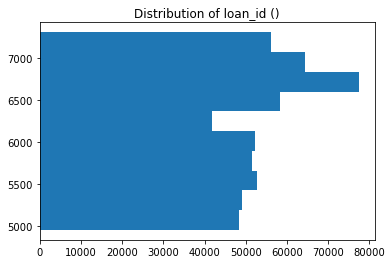

numeric


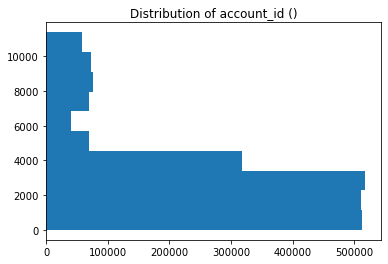

datetime


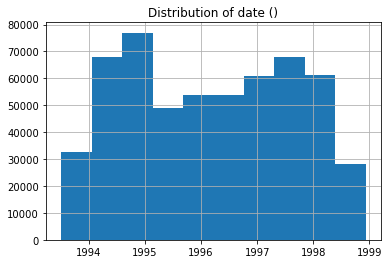

numeric


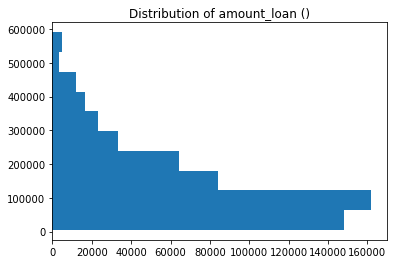

numeric


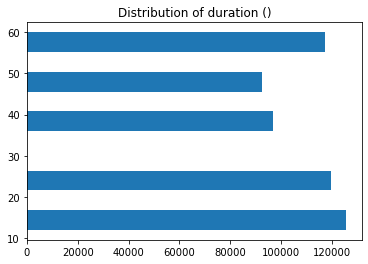

numeric


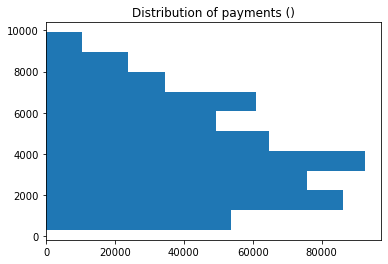

numeric


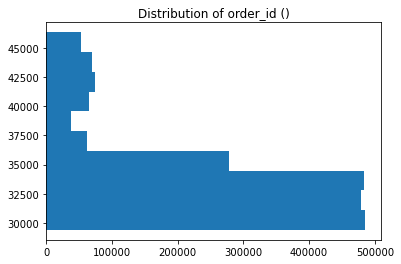

categorical


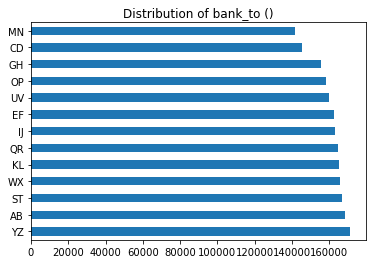

numeric


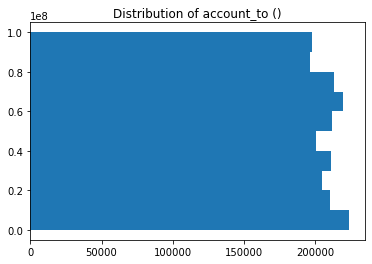

numeric


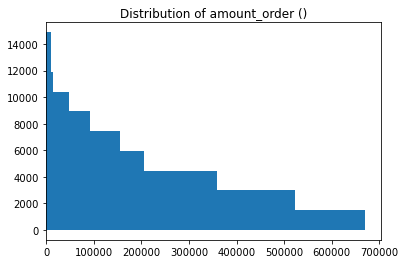

categorical


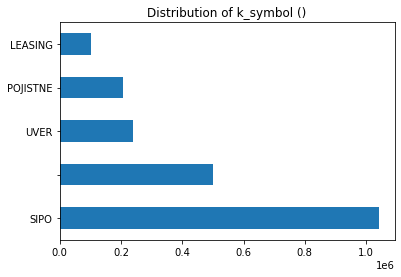

numeric


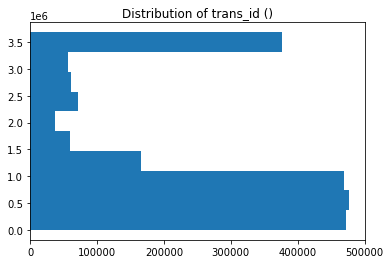

datetime


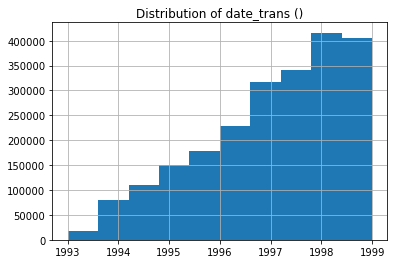

categorical


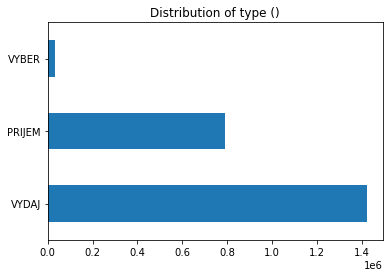

categorical


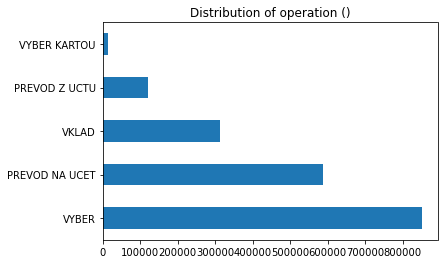

numeric


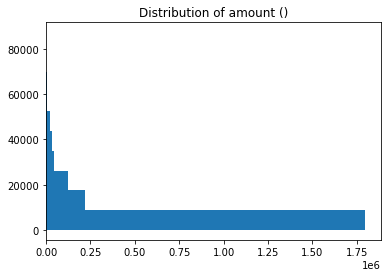

numeric


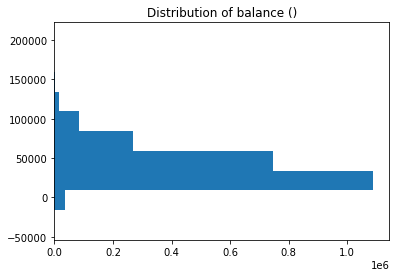

categorical


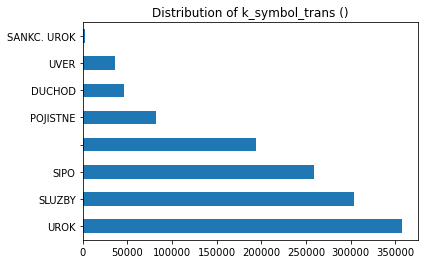

categorical


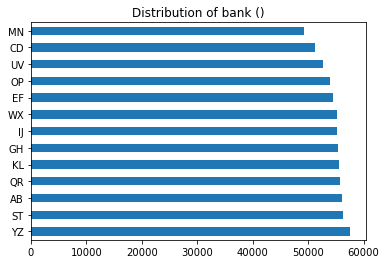

numeric


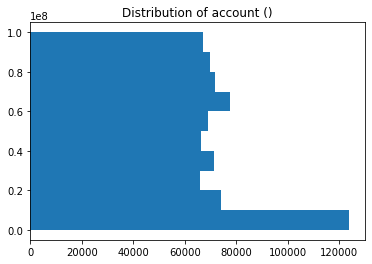

numeric


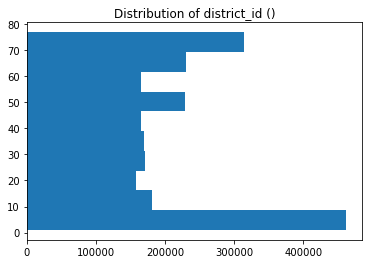

categorical


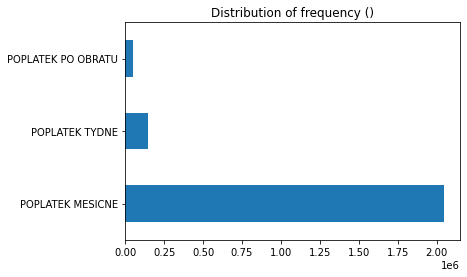

datetime


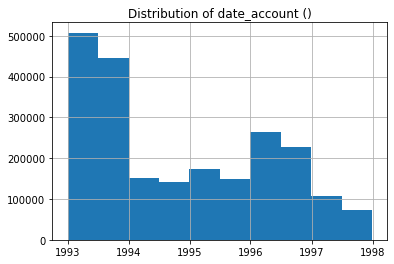

numeric


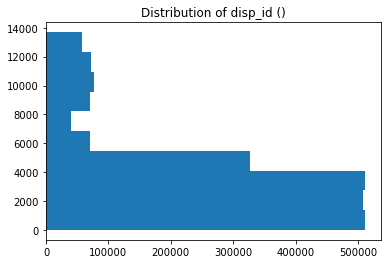

numeric


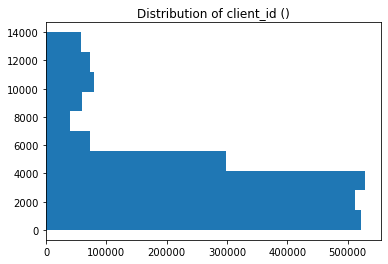

categorical


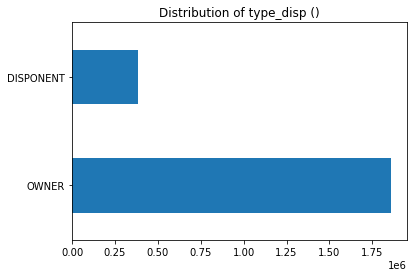

numeric


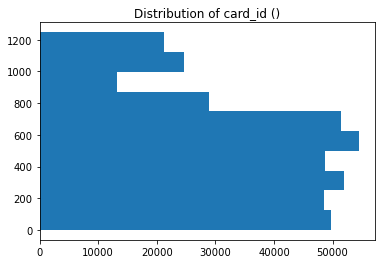

categorical


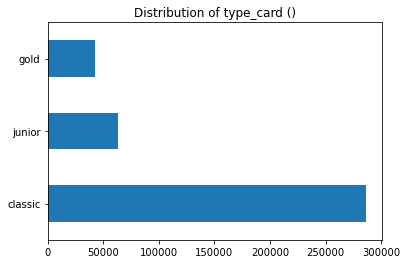

datetime


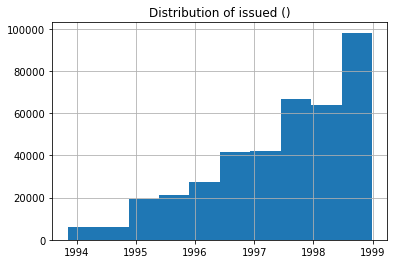

numeric


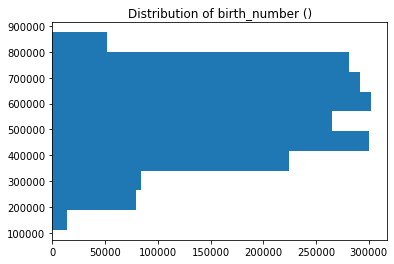

categorical


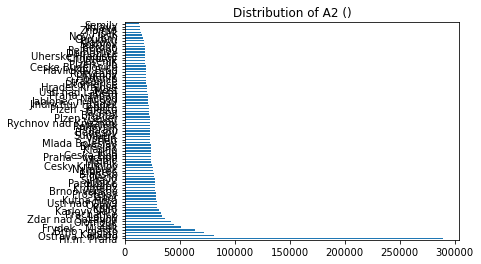

categorical


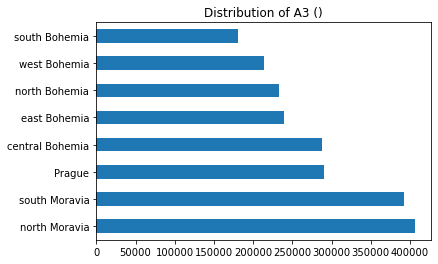

numeric


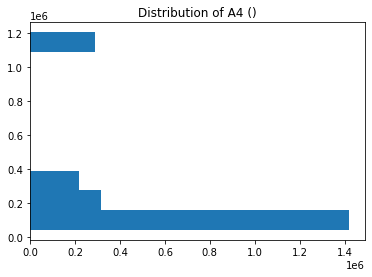

numeric


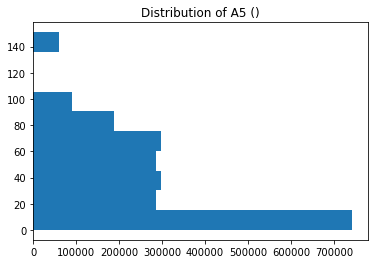

numeric


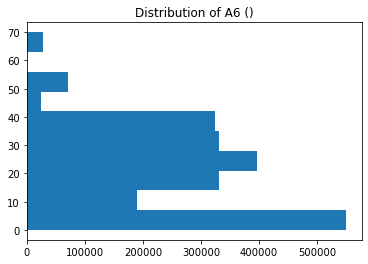

numeric


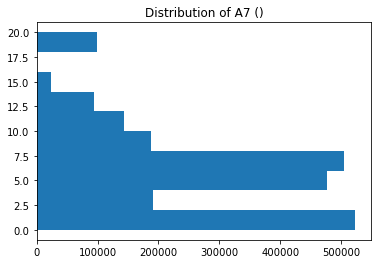

numeric


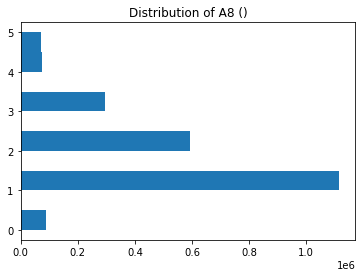

numeric


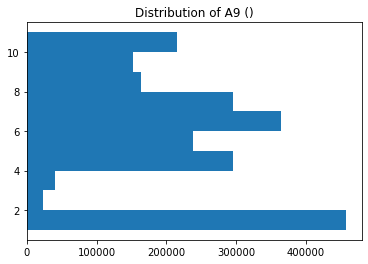

numeric


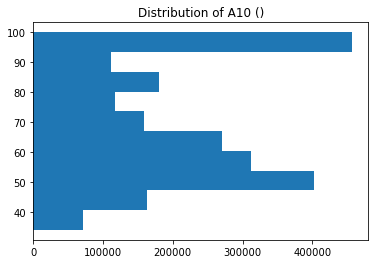

numeric


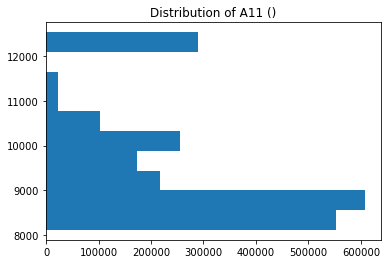

categorical


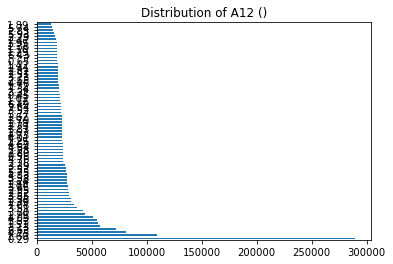

numeric


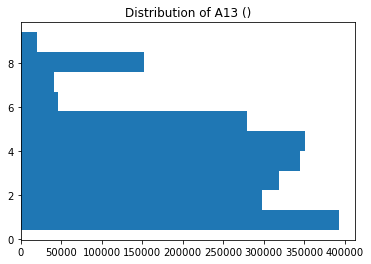

numeric


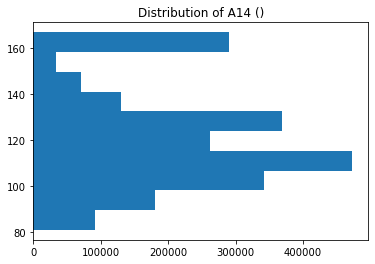

mixed
This is a column mixed of both numeric and non-numeric values


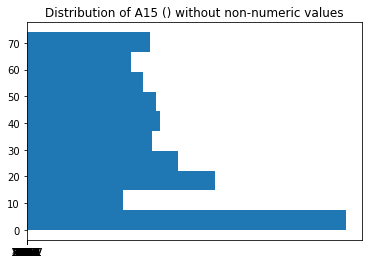

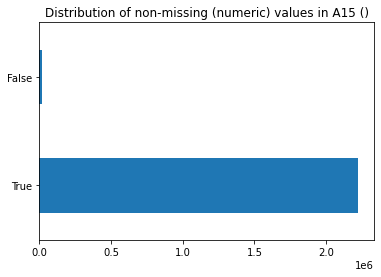

numeric


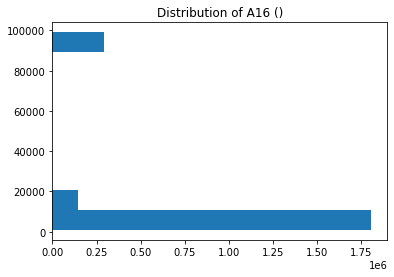

In [118]:
def plot_categorical(column, column_name, names_mask):
    column.value_counts().plot.barh()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_mixed(column, column_name, names_mask):
    print("This is a column mixed of both numeric and non-numeric values")
    check_numeric = column.str.isnumeric()
    check_numeric[check_numeric.isnull()] = True
    check_numeric[column.isnull()] = False

    plt.hist(column[check_numeric], orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]}) without non-numeric values')
    plt.show()

    check_numeric.value_counts().plot.barh()
    plt.title(f'Distribution of non-missing (numeric) values in {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_numeric(column, column_name, names_mask):
    plt.hist(column, orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()    

def plot_datetime(column, column_name, names_mask):
    column.hist()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()
    
def check_mixed_or_categorical(column):
    if is_string_dtype(column) == False:
        return(False)
    else:
        check_numeric = column.str.isnumeric()
        check_numeric[check_numeric.isnull()] = True
        check_numeric[column.isnull()] = False
        if len(column[check_numeric]) == 0:
            return("categorical")
        else:
            return("mixed")

def check_factor_plotting_type(column, column_name, names_mask):
    if column.dtype == pd.Series([np.datetime64("1995-05-05")]).dtype:
        return("datetime")
    elif check_mixed_or_categorical(column) != False:
        return(check_mixed_or_categorical(column))
    else:
        return("numeric")

def plot_all(column, column_name, names_mask, presumably_discrete_names = presumably_discrete_names):
    map_functions_to_types = {
        "categorical" : plot_categorical,
        "mixed" : plot_mixed,
        "numeric" : plot_numeric, 
        "datetime" : plot_datetime
    }
    
    type_checked = check_factor_plotting_type(column, column_name, names_mask)
    print(type_checked)
    map_functions_to_types[type_checked](column, column_name, names_mask)


for col in X_cat.columns:
    
    plot_all(X_cat[col], col, names_mask)


На графиках видно, что значения переменных распределены более или менее естественно, хотя некоторые переменные из категории AX заметно бимодальны (к сожалению, не удалось найти их интерпретации). Единственный график, который подсказывает наличие существенных выбросов - график для amount.

### Выбросы

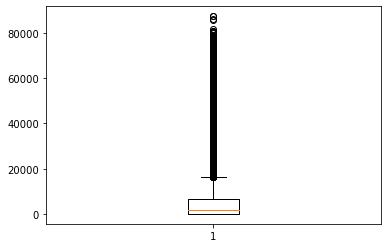

In [122]:
plt.boxplot(X_cat["amount"][X_cat["amount"].isnull() == False])
plt.show()


Пробуем их идентифицировать и убрать используя z-score. Видим, что аутлаеров с z-score > 3 не очень много, но при этом их устранение все равно не делает структуру данных более однородной.



Share of outliers in amount () is 0.028796961788843944
Mass of outliers in amount () is 0.21591328888599348
numeric


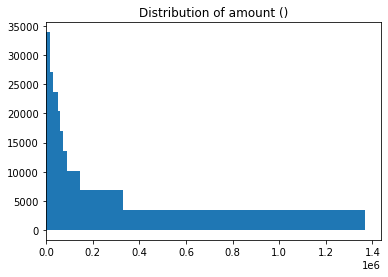

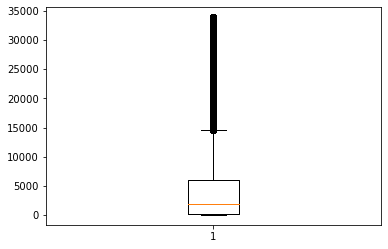

In [131]:
objects_with_outliers = ["amount"]

for column_with_outliers_name in objects_with_outliers:
    object_without_outliers = X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False][stats.zscore(X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False]) < 3]
    print(f"\n\nShare of outliers in {column_with_outliers_name} ({names_mask[column_with_outliers_name]}) is {1 - len(object_without_outliers) / X_cat.shape[0]}")
    print(f"Mass of outliers in {column_with_outliers_name} ({names_mask[column_with_outliers_name]}) is {1 - (object_without_outliers.sum()) / X_cat[column_with_outliers_name][X_cat[column_with_outliers_name].isnull() == False].sum()}")
    
    plot_all(object_without_outliers, column_with_outliers_name, names_mask)
    
    plt.boxplot(object_without_outliers)
    plt.show()

### Выводы

Датасет достаточно большой и подробный. К сожалению, данные о дефолтах есть только где-то для трети наблюдений, так что от остальных придется избавиться, что сильно его уменьшит. Кроме того, датасет полон пропусков, которые в нескольких колонках составляют более половины наблюдений. Другой проблемой является отсутствие интерпретации для факторов: в некоторых случаях (duration, amount_loan) это не проблема, но в других (A2, A3 и тд) затрудняет понимание. 